## Load packages and data

In [633]:
# Load packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.power import TTestIndPower
import sklearn
from sklearn.metrics import r2_score, mean_squared_error

# Supress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None

# Load data
data = pd.read_csv('hypothesis_testing_data.csv')

## Examine data

In [634]:
print("Variables:")
for col in data.columns:
    print("- " + col)
print('')

print('Number of observations: ' + str(len(data)))


Variables:
- sub
- age
- mean_fd
- area_of_end_region_1_mm2_InferiorFrontoOccipitalFasciculusL
- area_of_end_region_2_mm2_InferiorFrontoOccipitalFasciculusL

Number of observations: 566


## Split data in pilot, training, and testing sets

In [635]:
# This chunk was generated from this Chat-GPT conversation: https://chat.openai.com/c/465c3d30-40a0-4c90-824b-2b388f0bbbfe

# Create dictionary to hold assignments to different splits
splits = {}

# Pilot split
pilot = data.iloc[::3, :]
splits['Pilot'] = pilot['sub']

# Training split
training = data.iloc[1::3, :]
splits['Training'] = training['sub']

# Testing split
testing = data.iloc[2::3, :]
splits['Testing'] = testing['sub']

print('Number of observations in pilot: ' + str(len(pilot)))
print('Number of observations in training: ' + str(len(training)))
print('Number of observations in testing: ' + str(len(testing)))

# Add splits label to data frame
data['splits'] = np.nan
for i in splits.keys():
    data.loc[data['sub'].isin(splits[i]), 'splits'] = i

Number of observations in pilot: 189
Number of observations in training: 189
Number of observations in testing: 188


## Visualize raw data

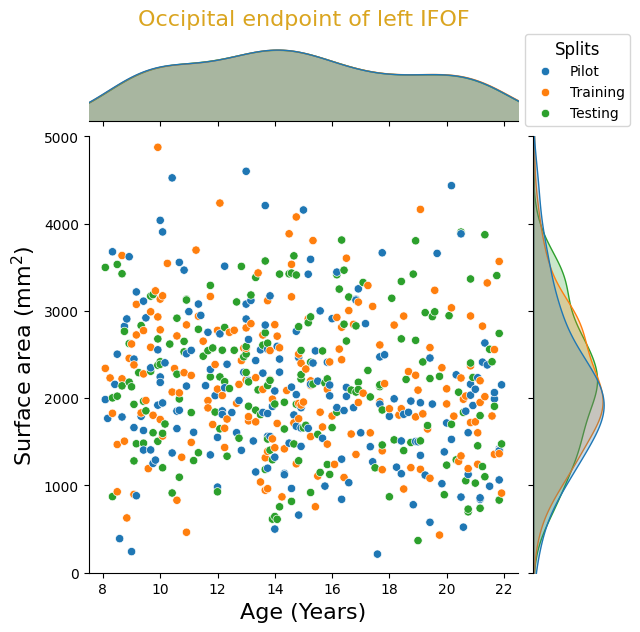

In [636]:
# Set figure size
plt.rcParams['figure.figsize'] = [6, 4]

# Create a jointplot with kind='kde'
sns.jointplot(data=data, x='age', y='area_of_end_region_1_mm2_InferiorFrontoOccipitalFasciculusL', hue='splits')

# Embellish plot
plt.xlabel('Age (Years)', fontsize=16)
plt.ylabel('Surface area (mm$^2$)', fontsize=16)
plt.title('Occipital endpoint of left IFOF', fontsize=16, pad=80, color='goldenrod')
plt.xticks(np.arange(8, 24, 2))
plt.xlim(7.5,22.5)
plt.ylim(0, 5000)
plt.legend(bbox_to_anchor=(1, 1.25), loc=2, title='Splits', title_fontsize=12)
plt.show()


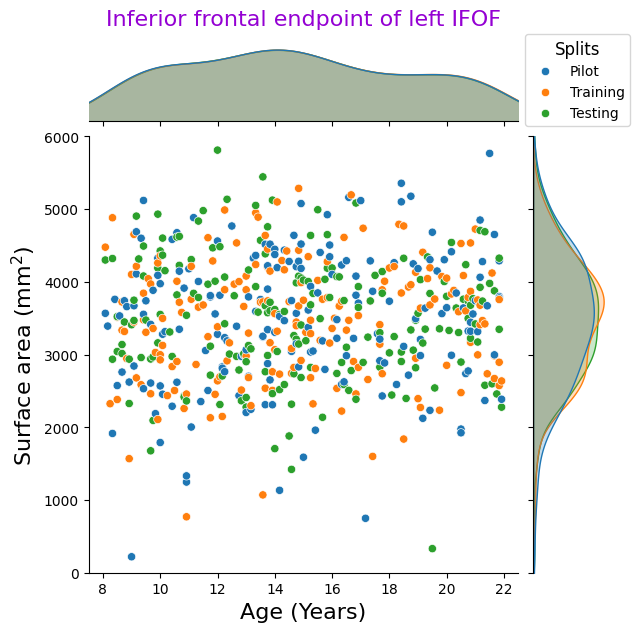

In [637]:
# Set figure size
plt.rcParams['figure.figsize'] = [6, 4]

# Create a jointplot with kind='kde'
sns.jointplot(data=data, x='age', y='area_of_end_region_2_mm2_InferiorFrontoOccipitalFasciculusL', hue='splits')

# Embellish plot
plt.xlabel('Age (Years)', fontsize=16)
plt.ylabel('Surface area (mm$^2$)', fontsize=16)
plt.title('Inferior frontal endpoint of left IFOF', fontsize=16, pad=80, color='darkviolet')
plt.xticks(np.arange(8, 24, 2))
plt.xlim(7.5,22.5)
plt.ylim(0, 6000)
plt.legend(bbox_to_anchor=(1, 1.25), loc=2, title='Splits', title_fontsize=12)
plt.show()

## Perform power analysis

### Plot model fit to pilot sample

Slope: 77.98558901373508
Standard error: 26.259712271013292
Z-score: 2.969780788490179
P-value: 0.0033708552093831747


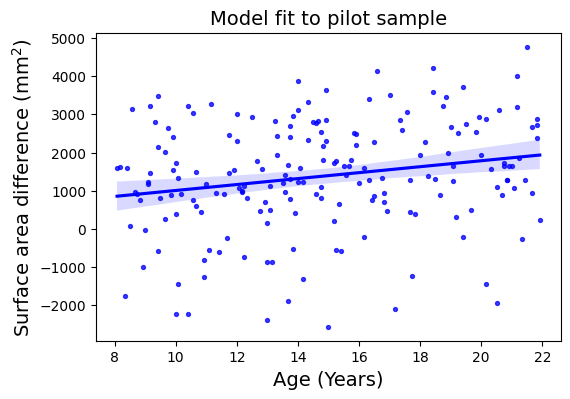

In [638]:
# Create variable called area_of_end_region_difference that is the difference between the occipital and inferior frontal endpoints (i.e. inferior frontal - occipital)
pilot['area_of_end_region_difference'] = pilot['area_of_end_region_2_mm2_InferiorFrontoOccipitalFasciculusL'] - pilot['area_of_end_region_1_mm2_InferiorFrontoOccipitalFasciculusL']

# Plot scatter plot for end region difference, including linear regression line
sns.regplot(x='age', y='area_of_end_region_difference', data=pilot, color='blue', scatter_kws={'s': 8, 'alpha': 0.75})

# Update axis labels
plt.xlabel('Age (Years)', fontsize=14)
plt.ylabel('Surface area difference (mm$^2$)', fontsize=14)
plt.title('Model fit to pilot sample', fontsize=14)

# Extract slope and intercept from linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(pilot['age'], pilot['area_of_end_region_difference'])

# Z-score the slope
z_score = slope / std_err

# Print slope, intercept, p-value
print('Slope: ' + str(slope))
print('Standard error: ' + str(std_err))
print('Z-score: ' + str(z_score))
print('P-value: ' + str(p_value))

Perform a power analysis to find the N you need at 80% power given α = 0.05 and an effect size from the preliminary data you have so far. 

80195 positive outcomes out of   100000 experiments (80.20 pct)


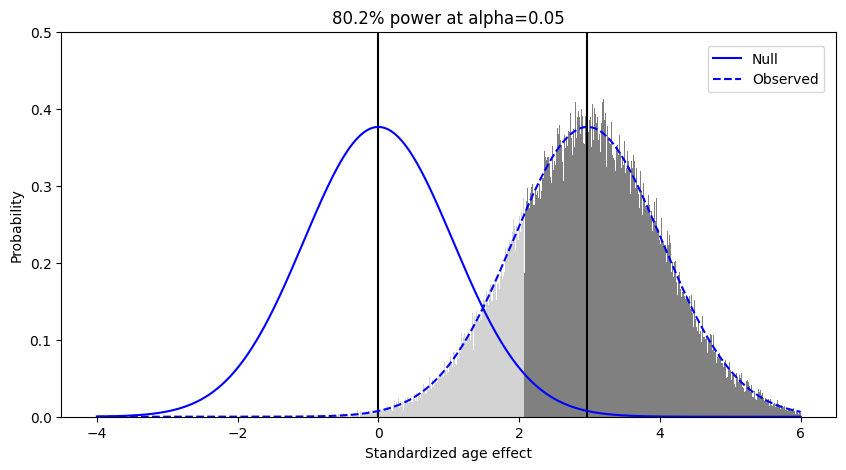

In [628]:
# Set seed
np.random.seed(0)

# Specify power
power = 0.8

# Specify null distribution (Gaussian centered at 0)
mu_0 = 0
old_sem = 1

# Specify alternative distribution using effect size observed in the pilot sample
new_effect_size = stats.norm.ppf(0.975) - stats.norm.ppf(1-power) # Assumes alpha = 0.05
mu_1 = z_score # Standardized age coefficient estimate
new_sem = (mu_1-mu_0)/new_effect_size

bin_size = 0.01
x_axis = np.arange(-4, 6+bin_size, bin_size)
x_edges = np.arange(x_axis[0]-bin_size/2, x_axis[-1]+bin_size, bin_size)

outcomes = np.random.normal(mu_1, new_sem, N)
outcome_is_positive = outcomes >= stats.norm.ppf(0.975, mu_0, new_sem)
print(f'{np.count_nonzero(outcome_is_positive)} positive outcomes out of \
  {N} experiments ({np.count_nonzero(outcome_is_positive)/N*100:.2f} pct)')

# We can plot these results as a normalized histogram
counts_no_effect, _ = np.histogram(outcomes[np.logical_not(outcome_is_positive)], bins=x_edges)
counts_effect, _    = np.histogram(outcomes[outcome_is_positive], bins=x_edges)
counts_all, _       = np.histogram(outcomes, bins=x_edges)
normalizer          = np.trapz(counts_all, dx=bin_size)

# Plot it
plt.figure(figsize=(10, 5))
plt.bar(x_axis, counts_no_effect/normalizer, width=0.01, color='lightgray')
plt.bar(x_axis, counts_effect/normalizer, width=0.01, color='gray')
plt.plot([mu_0, mu_0], [0, 0.6], 'k-')
plt.plot([mu_1, mu_1], [0, 0.6], 'k-')
plt.plot(x_axis, stats.norm.pdf(x_axis, mu_0, new_sem), 'b-', label='Null')
plt.plot(x_axis, stats.norm.pdf(x_axis, mu_1, new_sem), 'b--', label='Observed')
plt.xlabel('Standardized age effect')
plt.ylabel('Probability')
plt.ylim(0, 0.5)
plt.title('80.2% power at alpha=0.05')
plt.legend(loc='upper left', bbox_to_anchor=(0.825, 0.98))
plt.show()


## Fit linear and quadratic models to endpoint-specific data from the training set

### Add $Age^2$ to datasets

In [629]:
training['age_sq'] = training['age']**2
testing['age_sq'] = testing['age']**2

### Occipital tract ending

In [630]:
# Fit linear model for occipital endpoints
model_linear_occ = smf.ols(formula='area_of_end_region_1_mm2_InferiorFrontoOccipitalFasciculusL ~ age', data=training)
results = model_linear_occ.fit()
print(results.summary())

# Fir quadratic model for occipital endpoints
model_quadratic_occ = smf.ols(formula='area_of_end_region_1_mm2_InferiorFrontoOccipitalFasciculusL ~ age_sq + age', data=training)
results = model_quadratic_occ.fit()
print(results.summary())

                                                 OLS Regression Results                                                
Dep. Variable:     area_of_end_region_1_mm2_InferiorFrontoOccipitalFasciculusL   R-squared:                       0.015
Model:                                                                     OLS   Adj. R-squared:                  0.010
Method:                                                          Least Squares   F-statistic:                     2.825
Date:                                                         Thu, 09 Nov 2023   Prob (F-statistic):             0.0945
Time:                                                                 16:51:07   Log-Likelihood:                -1527.8
No. Observations:                                                          189   AIC:                             3060.
Df Residuals:                                                              187   BIC:                             3066.
Df Model:                               

### Inferior frontal ending

In [631]:
# Fit linear model for inferior frontal endpoints
model_linear_inf = smf.ols(formula='area_of_end_region_2_mm2_InferiorFrontoOccipitalFasciculusL ~ age', data=training)
results = model_linear_inf.fit()
print(results.summary())

# Fit quadratic model for inferior frontal endpoints
model_quadratic_inf = smf.ols(formula='area_of_end_region_2_mm2_InferiorFrontoOccipitalFasciculusL ~ age_sq + age', data=training)
results = model_quadratic_inf.fit()
print(results.summary())

                                                 OLS Regression Results                                                
Dep. Variable:     area_of_end_region_2_mm2_InferiorFrontoOccipitalFasciculusL   R-squared:                       0.008
Model:                                                                     OLS   Adj. R-squared:                  0.002
Method:                                                          Least Squares   F-statistic:                     1.421
Date:                                                         Thu, 09 Nov 2023   Prob (F-statistic):              0.235
Time:                                                                 16:51:07   Log-Likelihood:                -1532.3
No. Observations:                                                          189   AIC:                             3069.
Df Residuals:                                                              187   BIC:                             3075.
Df Model:                               

### Summary


| Ending | Model | $Age$ | $Age^2$ | Adjusted R-Squared | AIC |
| -- | -- | -- | -- | -- | -- | 
| Occipital | Linear | $\hat{\beta}_{Age} = $ -24.5595, t(281) = -2.27, p = 0.094 | -- | 0.010 | 3060 |
| Occipital | Quadratic | $\hat{\beta}_{Age} = $ 51.7708, t(280) = 0.434, p = 0.664 | $\hat{\beta}_{Age^2}$ = -2.5263, t(280) = -0.645, p = 0.519 | 0.007 | 3061 |
| Inferior frontal | Linear | $\hat{\beta}_{Age} = $ 17.8321, t(281) = 1.192, p = 0.235 | -- | 0.002 | 3069 |
| Inferior frontal | Quadratic | $\hat{\beta}_{Age} = $ 127.2594, t(280) = 1.044, p = 0.298 | $\hat{\beta}_{Age^2}$ = $ -3.6217, t(280) = -0.905, p = 0.367 | 0.025 | 3070 |

## Fit linear model to endpoint difference data from the training set

                                  OLS Regression Results                                 
Dep. Variable:     area_of_end_region_difference   R-squared:                       0.018
Model:                                       OLS   Adj. R-squared:                  0.013
Method:                            Least Squares   F-statistic:                     3.401
Date:                           Thu, 09 Nov 2023   Prob (F-statistic):             0.0667
Time:                                   16:51:07   Log-Likelihood:                -1613.5
No. Observations:                            189   AIC:                             3231.
Df Residuals:                                187   BIC:                             3237.
Df Model:                                      1                                         
Covariance Type:                       nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------

Text(0.5, 1.0, 'Model fit to training set')

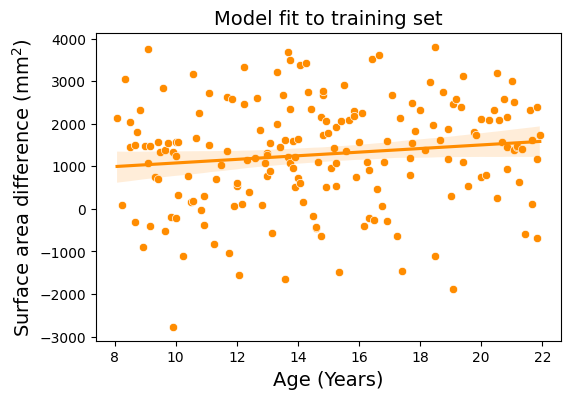

In [632]:
# Create variable called area_of_end_region_difference that is the difference between the occipital and inferior frontal endpoints (i.e. inferior frontal - occipital)
training['area_of_end_region_difference'] = training['area_of_end_region_2_mm2_InferiorFrontoOccipitalFasciculusL'] - training['area_of_end_region_1_mm2_InferiorFrontoOccipitalFasciculusL']
testing['area_of_end_region_difference'] = testing['area_of_end_region_2_mm2_InferiorFrontoOccipitalFasciculusL'] - testing['area_of_end_region_1_mm2_InferiorFrontoOccipitalFasciculusL']


# Fit linear model for area difference
model_linear_diff = smf.ols(formula='area_of_end_region_difference ~ age', data=training)
results = model_linear_diff.fit()
print(results.summary())

# Plot scatter plot for end region difference vs. age in the testing set, including an additional line for the predicted values (including standard error)
sns.scatterplot(x='age', y='area_of_end_region_difference', data=training, color='darkorange')
sns.regplot(x='age', y='area_of_end_region_difference', data=training, color='darkorange', scatter_kws={'s': 8, 'alpha': 0})
plt.ylabel('Surface area difference (mm$^2$)', fontsize=14)
plt.xlabel('Age (Years)', fontsize=14)

# Include title
plt.title('Model fit to training set', fontsize=14)

## Evaluate linear model in testing set

R-squared: -0.016136301444847678


Text(0.5, 1.0, 'Model evaluated on testing set')

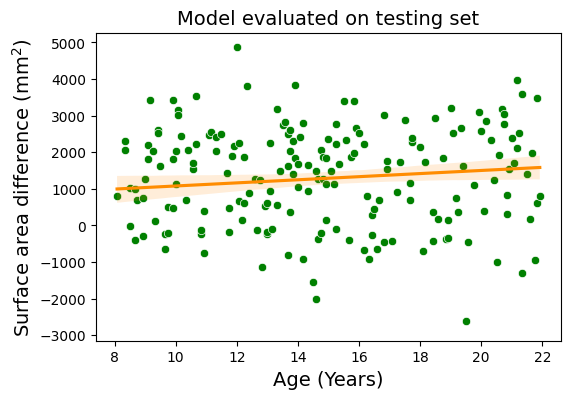

In [621]:
# For each observation for the 'age' variable in the 'testing' pandas dataframe, predict the value of the 'area_of_end_region_difference' variable using the linear model
testing['area_of_end_region_difference_predicted'] = results.predict(testing['age'])

# Calculate R-squared
r2 = r2_score(testing['area_of_end_region_difference'], testing['area_of_end_region_difference_predicted'])
print(f'R-squared: {r2}')

# Plot scatter plot for end region difference vs. age in the testing set, including an additional line for the predicted values (including standard error)
sns.scatterplot(x='age', y='area_of_end_region_difference', data=testing, color='green')
sns.regplot(x='age', y='area_of_end_region_difference', data=training, color='darkorange', scatter_kws={'s': 8, 'alpha': 0})
plt.ylabel('Surface area difference (mm$^2$)', fontsize=14)
plt.xlabel('Age (Years)', fontsize=14)

# Include title
plt.title('Model evaluated on testing set', fontsize=14)
